# Imports

In [1]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np

In [2]:
# Import data
df = pd.read_csv('data/maindata.csv')

# First Glance and Set creation

In [3]:
df.head()

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo
3,3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo
4,4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,NaN,Turista,Promo


In [4]:
# How many NAs
df.isna().sum()

Unnamed: 0          0
insert_date         0
origin              0
destination         0
start_date          0
end_date            0
train_type          0
price          310681
train_class      9664
fare             9664
dtype: int64

In [5]:
# Length of the dataset
len(df)

2579771

In [6]:
# Proportion of missing price values
df.isna().sum()['price'] / len(df)

0.12042968154925379

# Feature engineering and set creation

In [7]:
import datetime as dt
import time

In [8]:
# Convert date strings
df['insert_date'] = pd.to_datetime(df['insert_date'],
                                        infer_datetime_format=True)
df['start_date'] = pd.to_datetime(df['start_date'],
                                        infer_datetime_format=True)
df['end_date'] = pd.to_datetime(df['end_date'],
                                        infer_datetime_format=True)

In [9]:
# Time between end and start
df['traveltime'] = df['end_date'] - df['start_date']

In [10]:
# traveltime in minutes
temp1 = df['traveltime'].apply(lambda x: str(x))
timestring = temp1.replace(to_replace=r'0 days ', value='', regex=True)

In [11]:
# Convert timestring to seconds
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

df['traveltime_seconds'] = timestring.apply(lambda x: get_sec(x))
df['traveltime_seconds']

0          10560
1           9120
2           8460
3           9120
4           9840
5           9480
6           9720
7           9120
8           9120
9           9360
10          9120
11          9600
12          9300
13          9120
14          8460
15          9000
16          8460
17          9480
18          9120
19          9180
20          9480
21          9300
22          9600
23          9900
24         10560
25          9120
26          8460
27          9120
28          9840
29          9480
           ...  
2579741     9480
2579742     9300
2579743     8460
2579744     9600
2579745     9900
2579746    10560
2579747     9120
2579748     8460
2579749     9120
2579750     9840
2579751     9480
2579752     9720
2579753     9120
2579754     9120
2579755     9360
2579756     9120
2579757     9600
2579758     9300
2579759     9120
2579760     8460
2579761     9000
2579762     8460
2579763     9480
2579764     9120
2579765     9180
2579766     9480
2579767     9300
2579768     84

In [12]:
# Weekday variable - start date and end date weekdays
df['insert_day'] = df['insert_date'].dt.day_name()
df['start_day'] = df['start_date'].dt.day_name()
df['end_day'] = df['end_date'].dt.day_name()

In [13]:
# Month variable
df['insert_month'] = df['insert_date'].dt.month_name()
df['start_month'] = df['start_date'].dt.month_name()
df['end_month'] = df['end_date'].dt.month_name()

In [14]:
# drop dates
df = df.drop(['insert_date', 'start_date', 'end_date'], axis=1)

In [15]:
# Missing values will make our prediction set
df_work = df[df.price.notna()]
df_goal = df[df.price.isna()]

In [16]:
len(df_work)

2269090

In [17]:
len(df_goal)

310681

In [18]:
# Check if it worked correctly
(len(df) == len(df_goal) + len(df_work))

True

In [19]:
# Another check
(df_work.price.notna().sum() == len(df_work)) and (df_goal.price.isna().sum() == len(df_goal))

True

In [20]:
# Which train classes are there?
df.train_class.unique()

array(['Turista', 'Preferente', 'Turista con enlace', 'Turista Plus', nan,
       'Cama G. Clase', 'Cama Turista'], dtype=object)

# Visual Analysis

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# set plot size for jupyter notebook
plt.rcParams['figure.figsize'] = [10, 5]

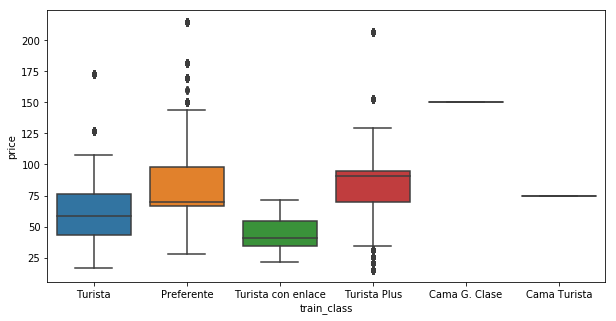

In [23]:
# Price and class
pc = sns.boxplot(x="train_class", y="price", data=df_work)

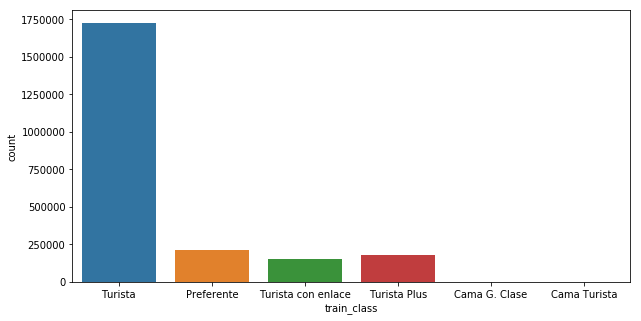

In [24]:
# bar plot on train class count
tcc = sns.countplot(data=df_work, x="train_class")

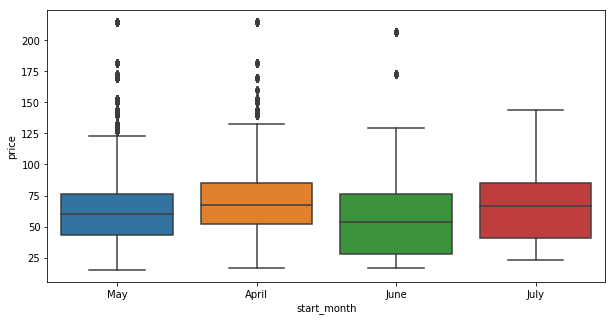

In [25]:
# Travel prices per month
tpm = sns.boxplot(x="start_month", y="price", data=df_work)

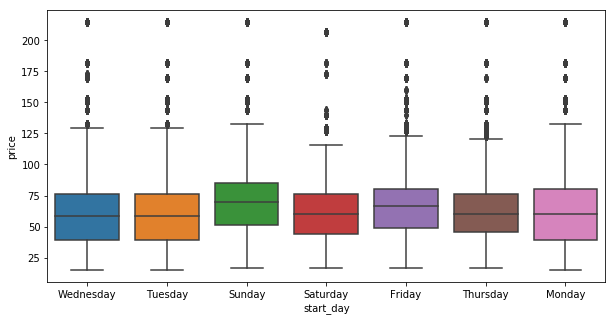

In [26]:
# Travel prices per day
tpd = sns.boxplot(x="start_day", y="price", data=df_work)

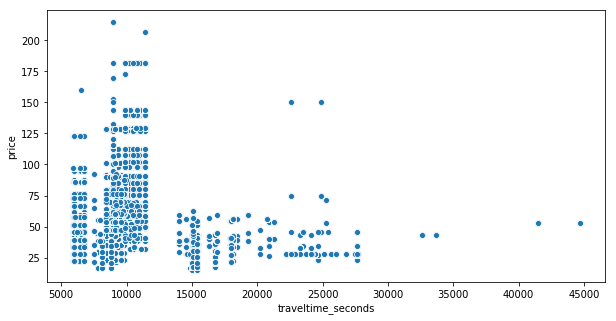

In [27]:
# price by travel time
ptt = sns.scatterplot(x="traveltime_seconds", y="price", data=df_work)

# One-Hot-Encoding

In [28]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [29]:
# Wich values need to be OH-encoded?
    # origin
    # destination
    # train_type
    # train_class
    # fare
    # insert_day
    # start_day
    # end_day
    # insert_month
    # start_month
    # end_month

In [30]:
# state encoder
oh_encoder = OneHotEncoder(sparse=False)

In [31]:
# checking types
df_work.dtypes

Unnamed: 0                      int64
origin                         object
destination                    object
train_type                     object
price                         float64
train_class                    object
fare                           object
traveltime            timedelta64[ns]
traveltime_seconds              int64
insert_day                     object
start_day                      object
end_day                        object
insert_month                   object
start_month                    object
end_month                      object
dtype: object

In [32]:
# changing column types for df_work and df_goal


obj_to_cat = ['origin', 'destination', 'train_type', 'train_class', 'fare',
              'insert_day', 'start_day', 'end_day', 'insert_month',
              'start_month', 'end_month']

for col in obj_to_cat:
    df_work[col] = df_work[col].astype('category')

for col in obj_to_cat:
    df_goal[col] = df_goal[col].astype('category')

C:\Users\cholz\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\cholz\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [33]:
# dropping traveltime
df_work = df_work.drop(['traveltime'], axis=1)
df_goal = df_goal.drop(['traveltime'], axis=1)

In [34]:
# oh-encoding
df_work_oh = pd.get_dummies(df_work)
df_goal_oh = pd.get_dummies(df_goal)

# Splits

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Dividing training set into X and y
X = df_work_oh.drop('price', axis=1)
y = df_work_oh.price

In [37]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [38]:
# import
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
# base model
linreg = LinearRegression()

In [40]:
# fitting
linearmodel = linreg.fit(X_train, y_train)

In [41]:
# print results
print(linearmodel.intercept_)
print(linearmodel.coef_)

105.77246589312995
[-1.74604245e-07 -8.24453548e-04  2.68769074e+01 -4.21703469e-01
 -9.71738128e+00 -3.08685781e+00 -1.36509649e+01  2.77927174e+01
  4.21703470e-01 -1.27913707e+01 -2.26969591e+00 -1.31533543e+01
  3.47415718e+00  7.28447975e+00  1.20745045e+01  2.62048914e+00
  6.37463299e+00  1.07151186e+01 -2.09618111e-01 -3.37051904e+00
 -6.79437180e+00  4.19297254e+00 -6.82557109e+00 -7.63359804e+00
 -2.03756279e+01 -8.10626715e-01 -7.16421989e-01  3.67024620e+01
  4.59841237e+00  2.16909632e+00 -2.07997871e+01 -1.12342183e+01
 -1.14359653e+01 -2.11862546e+01 -7.72786586e+00 -1.98101096e+01
  3.67024620e+01  7.48472280e+01 -3.70035623e+01 -2.58218977e+01
 -1.17042892e-01  1.21324543e-01 -1.07310917e-02  6.14980478e-02
 -2.19683444e-02  7.08481236e-02 -1.03928400e-01  3.74648613e-01
 -1.46584492e+00 -1.80783847e+00  5.05856753e+00  1.33192651e+00
 -2.14815739e+00 -1.34330187e+00  1.89645589e+00  9.79004172e-01
 -3.13316534e-01 -2.39651901e+00 -1.61376371e+00  7.51131559e-01
  6.97

In [42]:
# imports for p-values
import statsmodels.api as sm

In [43]:
# calculate p-values
mod = sm.OLS(y_train, X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

In [44]:
p_values <= 0.05

Unnamed: 0                   True
traveltime_seconds           True
origin_BARCELONA             True
origin_MADRID                True
origin_PONFERRADA            True
origin_SEVILLA               True
origin_VALENCIA              True
destination_BARCELONA        True
destination_MADRID           True
destination_PONFERRADA       True
destination_SEVILLA          True
destination_VALENCIA         True
train_type_ALVIA             True
train_type_AV City           True
train_type_AVE               True
train_type_AVE-LD            True
train_type_AVE-MD            True
train_type_AVE-TGV           True
train_type_INTERCITY         True
train_type_LD                True
train_type_LD-MD             True
train_type_MD                True
train_type_MD-AVE            True
train_type_MD-LD             True
train_type_R. EXPRES         True
train_type_REGIONAL          True
train_type_TRENHOTEL         True
train_class_Cama G. Clase    True
train_class_Cama Turista     True
train_class_Pr

In [52]:
# Make a test prediction
predlin = linearmodel.predict(X_test)

In [53]:
# MSE
print("Mean squared error: %.2f"
      % mean_squared_error(predlin, y_test))

Mean squared error: 111.58


In [54]:
# RMSE
print("RMSE: %.2f"
      % np.sqrt(mean_squared_error(predlin, y_test)))

RMSE: 10.56


In [56]:
# RSQUARED
print('R_squared: %.2f' % r2_score(predlin, y_test))

R_squared: 0.80


# Random Forest

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 20, random_state = 123)

In [ ]:
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# predict training data
predrf = rf.predict(X_test)